# Manipulating Spatial Data in DuckDB

This notebook demonstrates a workflow which is to **calculate the ratio of Airbnb listings to the total households in 30 travel-to-work areas (TTWAs) over time in Scotland**. 

Scotland has 45 TTWAs in total. We only have 30 TTWAs of Airbnb listings records.

Temporally, the record covers 2020-2023. We aggregate them in each month. 

The steps are
* open and load a large volume of Airbnb listing data containing geographic information.
* create geometry from lat/lng for the Airbnb listings and map them using the correct coordination system
* load the Intermediate Zone shapefile which contains household information.
* spatial join Airbnb listings to Intermediate Zone
* calculate a ratio of Airbnb listings to households for Intermediate Zones every month over the years


Let's connect to a database. You can use the existing or in-memory one. 

This time, we will switch to DuckDB's Python API. 
The syntax is straightforward. You create the connection by **Connect** then use **con.sql([SQL sentences]** to execute DB queries. 

In [1]:
import duckdb as dd

# Create / connect to database
con = dd.connect('my_database_exercise.db')
con.sql('SHOW TABLES;')


┌────────────────┐
│      name      │
│    varchar     │
├────────────────┤
│ listings       │
│ listings_focus │
└────────────────┘

DuckDB has the benefit of reading external files, such as JSON and Parquet very easily. </br>
JSON is an unstructured data format while Parquet is used to transfer very large, sometimes terabytes, datasets. </br>
They are the key formats of data used in OLAP and cloud-based data services. </br>
Efficiently reading, writing and manipulating them are one of the reasons for DuckDB becomes increasingly popular. </br>

Here I have a set of *.parquet' files. They are created for all the 30 TTWAs. </br>
DuckDB can read them and combine them directly without any overhead such as looping the files or creating a new large combined file. </br>
DuckDB connects to pandas and creates a dataframe directly from the combined files in memory making the whole process very efficient. </br>

In [3]:
df=con.sql("SELECT * FROM read_parquet('Data5/*.parquet')").df()
df.shape
df.columns

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['additional_hosts_count', 'additional_hosts_id_list',
       'amenities_missing', 'amenities_missing_count', 'amenities_present',
       'amenities_present_count', 'bathroom_label', 'bed_label',
       'bedroom_label', 'city', 'collected_day', 'collected_month',
       'collected_year', 'description', 'guest_label',
       'has_commercial_host_info', 'is_hosted_by_superhost', 'is_hotel', 'lat',
       'listing_amenities', 'listing_id', 'lng', 'localised_city',
       'max_nights', 'min_nights', 'name', 'primary_host_id',
       'property_type_in_city', 'room_and_property_type', 'room_type_category',
       'star_rating', 'state', 'summary', 'timestamp', 'geometry',
       'index_right', 'id', 'collect_calendars', 'collect_listing_details',
       'collect_reviews', 'scan_for_new_listings', 'collect_bookings',
       'ttwa_id', 'timestamp_dt'],
      dtype='object')

You can directly work with dataframe. But for this DB class, let's create a table and use it for in-DB analysis. 

In [6]:
# con.sql ("drop table listings;")
con.sql("create table listings as SELECT * FROM read_parquet('Data5/*.parquet')")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

You can check out the database to see if your table is there. 

In [7]:
# Create / connect to database
con = dd.connect('my_database_exercise.db')
con.sql('SHOW TABLES;')

┌──────────┐
│   name   │
│ varchar  │
├──────────┤
│ listings │
└──────────┘

The table is ready for quering. 

In [8]:
con.sql("select count(*) from listings")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1953727 │
└──────────────┘

For spatial analysis, we need DuckDB's spatial extensions. </br>
DuckDB now supports a wide range of geometrical and spatial operations, such as intersection, within, and spatial join. </br>
Please refer to their website for further information. </br>

One of the missing parts is the spatial index. </br>
The spatial process is very fast even without indexing thanks to DuckDB's unique data structure. 


In [3]:
# con.install_extension('spatial')
con.load_extension('spatial')

You can also check out a specific table about their fields and field types.

In [10]:
con.sql("DESCRIBE listings;")
# con.sql("select COLUMN_NAME from information_schema.columns where table_name = 'listings'")
# con.sql("SELECT * FROM listings limit 1")

┌──────────────────────────┬──────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│       column_name        │       column_type        │  null   │   key   │ default │  extra  │
│         varchar          │         varchar          │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────┼──────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ additional_hosts_count   │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ additional_hosts_id_list │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ amenities_missing        │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ amenities_missing_count  │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ amenities_present        │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ amenities_present_count  │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ bathroom_label           │ VARCHAR    

In [12]:
con.sql("select distinct city from listings;")

┌─────────────────────────────────────┐
│                city                 │
│               varchar               │
├─────────────────────────────────────┤
│ Edinburgh                           │
│ Newington                           │
│ Edinburgh New Town                  │
│ Lasswade                            │
│ Ormiston                            │
│ Aberlady                            │
│ Mayfield                            │
│ Mussleburgh                         │
│ Kirkliston                          │
│ Ratho                               │
│   ·                                 │
│   ·                                 │
│   ·                                 │
│ Oskaig                              │
│ Kilmany                             │
│ Abercrombie                         │
│ Kirknewton, near Wooler             │
│ Middleton                           │
│ Milfield, near Wooler               │
│ Scremerston, Berwick upon Tweed     │
│ Marvig, South Lochs, Isle of Lewis  │


The original listing table contains lat/lng fields. They are used to create points for each listing. 

**ST_Point** is used here to create the lat/lng pair. **ST_geomFromText** is then used to create geometry. I found the lat/lng pair has to be cast to text format. This is not handy. 

Any geographical data shall have a correct coordination system. 
You will find most of the dataset, e.g. GPS, JSON, are in WGS84 (epsg:4326).  
As we are in the Uk, we use **ST_Transform** to project the data to *British National Grid*, epsg:27700). 
We then name the geometry filed to *geometry* using **AS**. 

SQL also helps us **CAST** the *timestamp_dt* field from VARCHAR (String) format to proper date format. 
This is prepared for aggregating timestamp to month/year. 

Remember always check whether your transformation gives you correct results by looking at the tables and field types.
                                                                                

In [ ]:
# con.sql("select * from listings where city = 'Flotta';")

In [14]:
# con.sql("""drop table listings_focus;""")

con.sql("""
CREATE TABLE IF NOT EXISTS listings_focus  AS
    SELECT 
         ST_Transform(ST_GeomFromText(cast(ST_Point(lat, lng) as Text)),'epsg:4326','epsg:27700') as geometry,  
        CAST(CAST(timestamp_dt  AS DATE) as VARCHAR) AS timestemp_date,
        id,        
    FROM listings
    """)
con.sql("SHOW TABLES;")
con.sql("""describe listings_focus;""")
con.sql("""select count(*) from listings_focus;""")

# --timestamp_dt::TIMESTAMP as timestemp_dt,
#Limit 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1953727 │
└──────────────┘

In [15]:
con.sql("select * from listings_focus limit 5;")

┌──────────────────────────────────────────────┬────────────────┬───────┐
│                   geometry                   │ timestemp_date │  id   │
│                   geometry                   │    varchar     │ int32 │
├──────────────────────────────────────────────┼────────────────┼───────┤
│ POINT (417944.53787152265 634874.3443298336) │ 2020-10-01     │    63 │
│ POINT (417980.360697594 635358.6230898314)   │ 2020-10-01     │    63 │
│ POINT (417122.39544115274 634218.8840281508) │ 2020-10-01     │    63 │
│ POINT (404690.44140013953 643855.2370276643) │ 2020-10-01     │    63 │
│ POINT (416038.8827417154 635528.081851549)   │ 2020-10-01     │    63 │
└──────────────────────────────────────────────┴────────────────┴───────┘

In [4]:

df=con.sql("""select * EXCLUDE geometry, ST_AsText(geometry) as geometry from listings_focus;""").df()
# f=con.sql("""select * EXCLUDE geometry, ST_GeomFromWKB(geometry) AS geometry from listings_focus;""").df()
df.head()


,timestemp_date,id,geometry
0,2020-10-01,63,POINT (417944.53787152265 634874.3443298336)
1,2020-10-01,63,POINT (417980.360697594 635358.6230898314)
2,2020-10-01,63,POINT (417122.39544115274 634218.8840281508)
3,2020-10-01,63,POINT (404690.44140013953 643855.2370276643)
4,2020-10-01,63,POINT (416038.8827417154 635528.081851549)


Here I include some extra code to demonstrate how tables with geographic information can be exported, imported and mapped through dataframes in **GeoPandas**. </br>
This is useful because </br>
(a) Databases like DuckDB are used for processing and manipulating large dataset </br>
(b) Visualization normally happen outside the DB. 

In [5]:
import geopandas as gpd

Taking the Dataframe, **GeoPandas** makes the projection and construct geoDataFame. 

In [6]:
gdf=gpd.GeoDataFrame(df)
gdf['geometry'] = gpd.GeoSeries.from_wkt(gdf['geometry'],crs="EPSG:27700")
gdf = gdf.set_geometry('geometry')
gdf.head()
gdf.shape



(1953727, 3)

We use Leafmap for visualization. 
              
Leafmap is a Python package for geospatial analysis and interactive mapping in a Jupyter environment.</br>
It is powerful because it has six plotting backends, including folium, ipyleaflet, plotly, pydeck, kepler.gl, and heremap.</br>
All of them are powerful individually. </br>
Go to  __[Leafmap](https://leafmap.org/get-started/)__ for more information. </br>

You can try different backends for large data. </br>
In our case, the default ipyleaflet backend is struggling. </br>
We decide to use __[lonboard](https://github.com/developmentseed/lonboard)__ instead.</br>
Lonboard is another emerging library for fast vector data visualization using GPU-based map rendering. </br>
It is not yet mature but very fast indeed. 
              

In [ ]:
# import leafmap as leafmap
# m = leafmap.Map()
# m.add_gdf(gdf, layer_name="listings_focus")
# m

In [ ]:
 # %pip install -U lonboard 


In [7]:

import leafmap.deckgl as leafmap

m = leafmap.Map(zoom=0.8)
m.add_gdf(gdf, zoom_to_layer=True, pickable=True)
m

Map(custom_attribution='', layers=(ScatterplotLayer(get_fill_color=[255, 0, 0, 180], get_radius=10.0, table=ar…

It is convenient to export *DataFrame* to *GeoJSON*. </br>
You need to take extra care of the geometry field. </br>
It needs to be saved as Text in dataframe then loaded using **from_wkt** in GeoDataFrame. </br>
At the moment, it is not perfect. I hope future releases will provide better solution. 

In [9]:
df = con.sql("""
         select * exclude geometry, ST_AsText(geometry) as geometry from listings_focus

       """).to_df()
df.shape
gdf = gpd.GeoDataFrame(df,geometry= gpd.GeoSeries.from_wkt(df['geometry']),crs="EPSG:27700")#
# # gdf.crs
gdf.head()
gdf.to_file("output_data5/Listing_focus_pdProjected_full.geojson",driver="GeoJSON")

In [ ]:
gdf=gpd.read_file("output_data5\Listing_focus_pdProjected_full.geojson")
gdf.head()
gdf.shape

In [10]:
gdf1=gpd.read_file("output_data5\Listing_focus_pdProjected_full.geojson").to_crs(27700)
gdf1.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

If in pure Python, we would achieve the goal by joining the Intermediate Zone shapefile with the listing dataframe. </br>
Something like this: 

<Axes: >

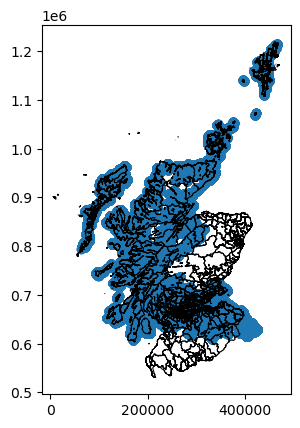

In [11]:
gdf2=gpd.read_file('DataShapefiles\SG_IntermediateZone_Bdry_2011.shp')
gdf2.crs
ax=gdf1.plot()
gdf2.plot(ax=ax, facecolor="none", 
              edgecolor='black', lw=0.7)



In [14]:
gdf_sel=gdf1.sjoin(gdf2,how='inner',predicate='within')
gdf_sel.shape

(1853580, 11)

Now we see how spatial join happens in DuckDB.</br>

As illustrated before, we create point geometry from Lat/lng for listings. </br>
The project them to *British National Grid*. 
The timestemps are tidied up. 

In [17]:
# con.sql("""drop table TestSwap; """)
con.sql("""
    Create table if not exists listings_proj as(
        SELECT 
                ST_Transform(ST_GeomFromText(cast(ST_Point(lat, lng) as Text)),'epsg:4326','epsg:27700') AS geometry,  
                CAST(CAST(timestamp_dt AS DATE) as VARCHAR) AS timestemp_date,
                id,        
            FROM listings
        )""")
con.sql ("""select geometry, id,timestemp_date FROM listings_proj limit 3""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────────────────────────────┬───────┬────────────────┐
│                   geometry                   │  id   │ timestemp_date │
│                   geometry                   │ int32 │    varchar     │
├──────────────────────────────────────────────┼───────┼────────────────┤
│ POINT (417944.53787152265 634874.3443298336) │    63 │ 2020-10-01     │
│ POINT (417980.360697594 635358.6230898314)   │    63 │ 2020-10-01     │
│ POINT (417122.39544115274 634218.8840281508) │    63 │ 2020-10-01     │
└──────────────────────────────────────────────┴───────┴────────────────┘

In [18]:
con.sql("""show tables""")
con.sql("""select count(*) from listings_proj""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1953727 │
└──────────────┘

We load the Intermediate Zone shapefile making sure the geometry is loaded using **ST_GeomFromText** after reading them as text. </br>
Note that the shapefile is already in British National Grid.
We keep *HHCNt2011* which is the total number of households and skip other fields when create the IZs_gen table. 

In [ ]:
con.sql("""SELECT ST_GeomFromText(cast(geom as Text)) as geometry from 'DataShapefiles/SG_IntermediateZone_Bdry_2011.shp' limit 3""")

In [ ]:
# con.sql("""drop table IZs""")

con.sql("""
    Create table if not exists IZs as(SELECT * from 'DataShapefiles/SG_IntermediateZone_Bdry_2011.shp')
        """)
con.sql("""describe IZs""")

con.sql("""SELECT * from IZs limit 3""")


In [21]:
# con.sql("""drop table IZs_Gen""")
con.sql("""
    Create table if not exists IZs_Gen as(
        (SELECT ST_GeomFromText(cast(geom as Text)) as geometry,name,HHCnt2011 from IZs) 
        )""")
con.sql ("""select geometry, name FROM IZs_Gen limit 3;""")
con.sql("""describe IZs_Gen""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ geometry    │ GEOMETRY    │ YES     │ NULL    │ NULL    │ NULL    │
│ Name        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ HHCnt2011   │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

The created IZ_Gen can be visulized either using GeoPandas plot function or Leapmap. 

<Axes: >

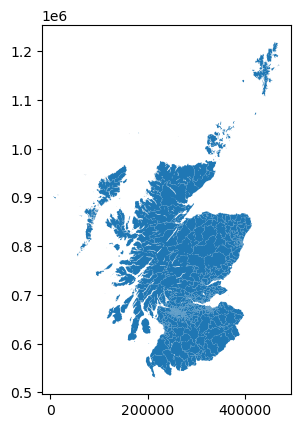

In [22]:


df_iz=con.sql("SELECT * exclude geometry, st_asText(geometry) as geometry FROM IZs_Gen").df()
df_iz.head()
df_iz['geometry'] = gpd.GeoSeries.from_wkt(df_iz['geometry'])
gdf_iz=gpd.GeoDataFrame(df_iz, geometry='geometry').set_crs('epsg:27700')
gdf_iz.head()
gdf_iz.to_file("output_data5/IZs_fromShape3.geojson", driver="GeoJSON")
gdf_iz.plot()


In [23]:
import leafmap.deckgl as leafmap

m = leafmap.Map(center=[20, 0], zoom=1.2)
m.add_gdf(gdf_iz, zoom_to_layer=True, pickable=True)
m.add_gdf(gdf_sel, zoom_to_layer=True, pickable=True)

m

Map(custom_attribution='', layers=(SolidPolygonLayer(get_fill_color=[0, 0, 255, 128], table=arro3.core.Table
-…

We are now ready to select listings within Intermediate Zones. </br>

The spatial function used in **ST_intersects**. 
For all the spatial functions that is supported by DuckDB, please go __[https://duckdb.org/docs/extensions/spatial/functions](https://duckdb.org/docs/extensions/spatial/functions)__ for more information. 

The syntax is creating a **Join** table. 
This join table is created based on the *spatial* join function linking listings and Intermediate Zones through their spatial relationships.

We count total number of listings within Intermediate Zone boundary. </br>
Can you tell the difference to the original listings?

In [25]:
##could be very slow
con.sql("""
    SELECT
        count(Lsts.id) AS listing_id,
    FROM 
            (SELECT 
            geometry, id        
            FROM listings_proj) as Lsts
        JOIN 
            (SELECT geometry,name, from IZs_Gen) as IZs
    
        ON ST_intersects(Lsts.geometry, IZs.geometry)
    
""")
#WHERE IZs.NAME = 'Kintyre Trail';

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┐
│ listing_id │
│   int64    │
├────────────┤
│      38023 │
└────────────┘

Instead of count the total valid listings, we can let the join output the listings_id, timestemp_date and IZ.Name. </br>
Note that listing_id and timestemp_date come form listing table (called Lsts now) while IZs comes from Intermediate Zone table (called IZs now). 

In [ ]:
  con.sql("""      
          Select lsts.id, lsts.timestemp_date, IZs.Name from (
            (SELECT * from listings_proj) as lsts
                JOIN 
            (Select * from IZs_Gen) as IZs                               
            ON ST_intersects(Lsts.geometry, IZs.geometry)     
        ) limit 5
        """)

Finally, we can construct a table which contains some more complex calcualations besed on the spatial join table called IZCountLsts. </br>
We count total number of listings and a ratio of listings to total households called listingRatio.</br>
They are aggregated numbers on not only IZs but also month and year. 

Can you tell the overall structure of this query?


In [ ]:
con.sql("""
    WITH IZCountLsts AS (

      Select lsts.id, lsts.timestemp_date , IZs.Name, IZs.HHCnt2011 from 
        (
            (SELECT * from listings_proj) as lsts
                JOIN 
            (Select * from IZs_Gen) as IZs                               
            ON ST_intersects(Lsts.geometry, IZs.geometry)     
        ) limit 5000
    )
SELECT
    count(distinct izcl.id) as listings, 
    monthname(cast(timestemp_date as date)) as month, 
    year(cast(timestemp_date as date)) as year, 
    izcl.Name as intermediateZone, 
    (count(distinct izcl.id)/izcl.HHCnt2011)*100 as listingRatio
FROM
    IZCountLsts as izcl
group by 
    intermediateZone, month,year, HHCnt2011
Order by 
    month,year
;
""")
# strptime(CAST(integer_date AS VARCHAR), '%Y%m%d')


In [26]:
# con.sql("""drop table listingGrpMonthly""")

con.sql("""
Create Table listingGrpMonthly as (
    WITH IZCountLsts AS (

      Select lsts.id, lsts.timestemp_date , IZs.Name, IZs.HHCnt2011 from 
        (
            (SELECT * from listings_proj) as lsts
                JOIN 
            (Select * from IZs_Gen) as IZs                               
            ON ST_intersects(Lsts.geometry, IZs.geometry)     
        ) 
    )
SELECT
    count(distinct izcl.id) as listings, 
    monthname(cast(timestemp_date as date)) as month, 
    year(cast(timestemp_date as date)) as year, 
    izcl.Name as intermediateZone, 
    (count(distinct izcl.id)/izcl.HHCnt2011)*100 as listingRatio
FROM
    IZCountLsts as izcl
group by 
    intermediateZone, month,year, HHCnt2011
Order by 
    month,year
)
;""")
# strptime(CAST(integer_date AS VARCHAR), '%Y%m%d')
#limit 5000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Finally, we close the connection the our DB. 

In [27]:
con.close()

# Some final reflections
We illustrate a workflow which uses two geographical datasets to generate more information. </b>
The workflow is developed in DuckDB. </b>
The output has been stored in a table which will be used by a text-as-query application. </b>

Now, it is your turn for some exercises. </b>
Please 
* use the provided Edinburgh listing data and update SQL accordingly
* use the same data to calculate **listing per KM area** for each intermediate zone per month year;
* show a map of the latest one month **listing per KM area** value


